In [2]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv(r'train.csv', dtype = np.float32) 

targets_np = train.label.values
features_np = train.loc[: , train.columns != 'label'].values / 255 #normalization

features_train , features_test , target_train, target_test = train_test_split(features_np,targets_np, 
                                                                              test_size = 0.2, random_state = 42)
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(target_train).type(torch.LongTensor)

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(target_test).type(torch.LongTensor)

batch_size = 100
n_iter = 15000
n_epochs = int(n_iter/(len(features_train) / batch_size )) 

Train = torch.utils.data.TensorDataset(featuresTrain , targetsTrain)
Test = torch.utils.data.TensorDataset(featuresTest , targetsTest)

TrainLoader = torch.utils.data.DataLoader(Train , batch_size = batch_size , shuffle = False)
TestLoader = torch.utils.data.DataLoader(Test , batch_size = batch_size , shuffle = False)


In [4]:
from torch import nn, optim
import torch.nn.functional as F
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784 , 256)
        self.fc2 = nn.Linear(256 , 128)
        self.fc3 = nn.Linear(128 ,64)
        self.fc4 = nn.Linear(64 , 10)
        self.dropout = nn.Dropout(p = 0.2)
        
    def forward(self , x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = torch.sigmoid(self.fc4(x))
        
        return x
        

In [5]:

model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters() , lr = 0.3)

test_losses = []
train_losses = []
accuracy_list = []
iteration_list = []
count = 0
for e in range(n_epochs):
    #print('Epoch {}/{}'.format(e , n_epochs))
    running_loss = 0
    for images , labels in TrainLoader:
        images = images.view( images.shape[0],-1)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
        
        
    else:
        test_loss = 0;
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for images , labels in TestLoader:
                images = images.view(images.shape[0] , -1)
                output = model(images)
                test_loss += criterion(output,labels)
                
                predicted = torch.max(output.data ,1 )[1]
                
                equals = predicted == labels
                accuracy += torch.mean(equals.type(torch.FloatTensor)) 
            
            model.train()
            
            
            train_losses.append(running_loss/len(TrainLoader))
            test_losses.append(test_loss/len(TestLoader))
            accuracy_list.append(accuracy/len(TestLoader))
            iteration_list.append(count)
           
           
            print("Epoch: {}/{}".format(e+1 , n_epochs),
                "Iteration: {}..".format(iteration_list[-1]),
                 "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                 "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                 "Test Accuracy: {:.3f}".format(accuracy_list[-1] ))
            
print('training Completed');

Epoch: 1/44 Iteration: 336.. Training Loss: 2.031..  Test Loss: 1.727..  Test Accuracy: 0.601
Epoch: 2/44 Iteration: 672.. Training Loss: 1.683..  Test Loss: 1.611..  Test Accuracy: 0.762
Epoch: 3/44 Iteration: 1008.. Training Loss: 1.612..  Test Loss: 1.580..  Test Accuracy: 0.784
Epoch: 4/44 Iteration: 1344.. Training Loss: 1.587..  Test Loss: 1.563..  Test Accuracy: 0.817
Epoch: 5/44 Iteration: 1680.. Training Loss: 1.568..  Test Loss: 1.548..  Test Accuracy: 0.829
Epoch: 6/44 Iteration: 2016.. Training Loss: 1.556..  Test Loss: 1.542..  Test Accuracy: 0.855
Epoch: 7/44 Iteration: 2352.. Training Loss: 1.546..  Test Loss: 1.534..  Test Accuracy: 0.873
Epoch: 8/44 Iteration: 2688.. Training Loss: 1.534..  Test Loss: 1.517..  Test Accuracy: 0.935
Epoch: 9/44 Iteration: 3024.. Training Loss: 1.522..  Test Loss: 1.515..  Test Accuracy: 0.937
Epoch: 10/44 Iteration: 3360.. Training Loss: 1.516..  Test Loss: 1.510..  Test Accuracy: 0.943
Epoch: 11/44 Iteration: 3696.. Training Loss: 1.511

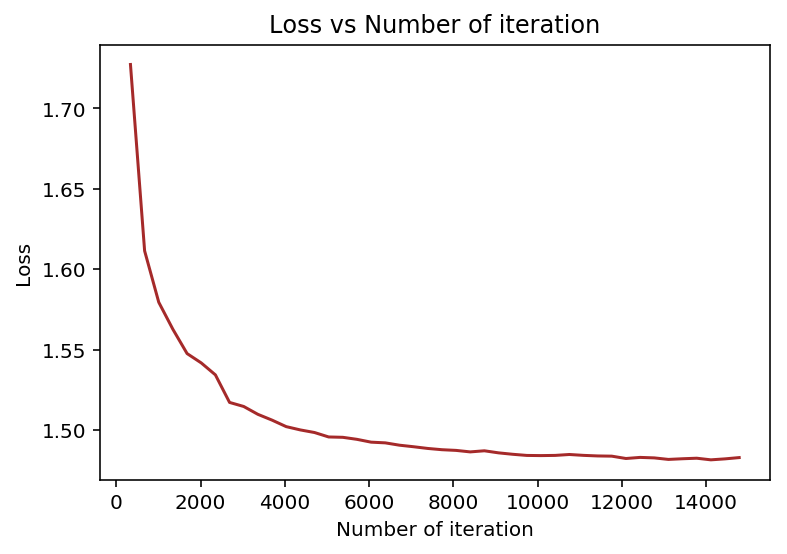

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(iteration_list,test_losses , color = 'brown')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Loss vs Number of iteration")
plt.savefig('images/los_iter.png')

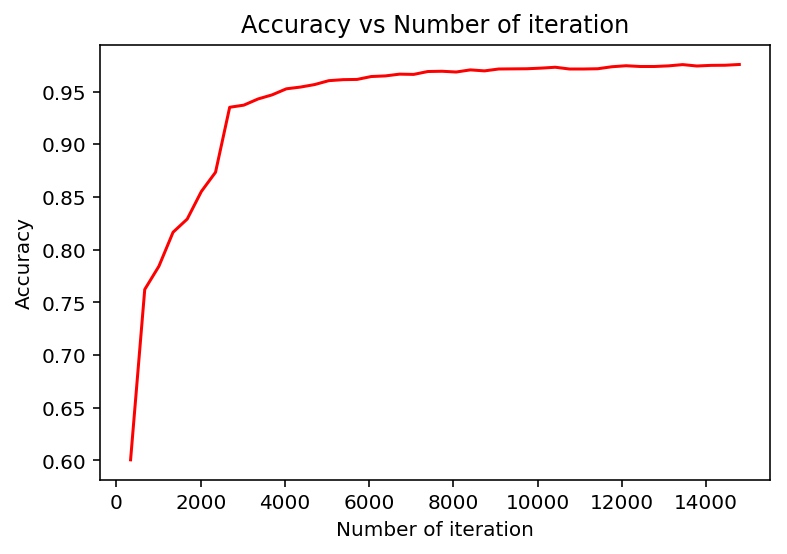

In [23]:

# visualization accuracy 
plt.plot(iteration_list , accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of iteration")
plt.savefig('images/acc_iter.png')


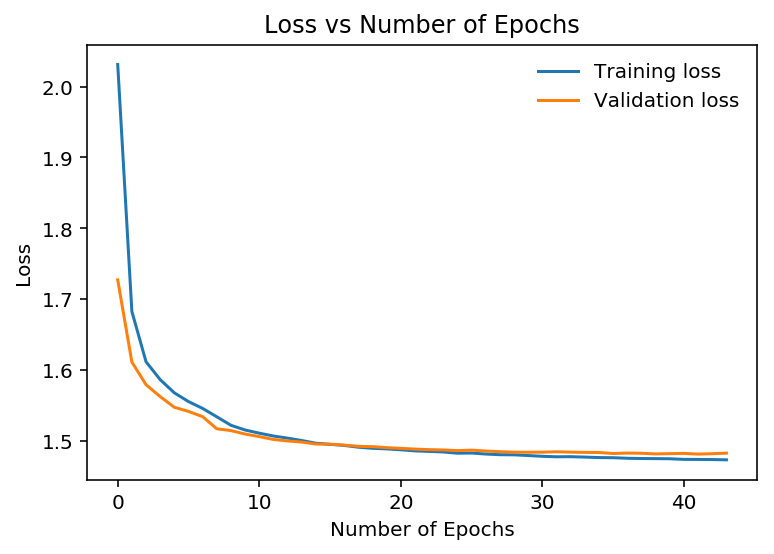

In [22]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Epochs")
plt.legend(frameon = False)
plt.savefig('images/losses_epochs.png')

In [21]:
test = pd.read_csv('test.csv')
x_test = test.values
x_test = x_test.reshape([-1, 28, 28]).astype(float)
x_test = x_test / 255
x_test = torch.from_numpy(np.float32(x_test))
x_test.shape

torch.Size([28000, 28, 28])

In [8]:
model.eval()
pred = model(x_test.float())
pred = torch.argmax(pred, 1)
print('Prediction: ', pred)


Prediction:  tensor([2, 0, 9,  ..., 3, 9, 2])


In [9]:
def export_csv(model_name, predictions):
    df = pd.DataFrame(predictions.tolist(), columns=['Label'])
    df['ImageId'] = df.index + 1
    file_name = f'submission_{model_name}.csv'
    print('Saving ',file_name)
    df[['ImageId','Label']].to_csv(file_name, index = False)

In [15]:
export_csv('model',pred)
torch.save(model.state_dict(), 'model.ckpt')

Saving  submission_model.csv


In [11]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0103, -0.0011, -0.0310,  ...,  0.0201,  0.0289,  0.0314],
                      [-0.0074, -0.0218, -0.0075,  ...,  0.0013,  0.0038,  0.0051],
                      [-0.0125, -0.0176, -0.0110,  ...,  0.0021,  0.0141, -0.0110],
                      ...,
                      [ 0.0173, -0.0030, -0.0049,  ..., -0.0232,  0.0337, -0.0322],
                      [ 0.0302,  0.0315,  0.0193,  ..., -0.0036, -0.0225,  0.0096],
                      [ 0.0191,  0.0341,  0.0032,  ..., -0.0086,  0.0218, -0.0052]])),
             ('fc1.bias',
              tensor([-7.0037e-02,  3.9730e-02,  1.1982e-01,  2.9397e-02, -1.3021e-02,
                       1.8387e-02, -2.8701e-02,  2.3816e-02, -2.5060e-03,  6.3885e-03,
                      -5.9278e-02, -3.8626e-02, -9.4714e-03,  8.6655e-03, -4.6272e-02,
                      -3.1464e-02,  3.0889e-02, -4.8184e-03, -7.0410e-02, -5.8923e-02,
                       3.2441e-02, -2.0425e-02, -1.3043e-01,  1.